# FreeTrace tutorial

# Requirements</br>
Linux (python3.10 or &uarr;) with gpu.</br>
[Nvidia Cuda installation](https://developer.nvidia.com/cuda-toolkit)

# FreeTrace installation

In [31]:
"""
This includes installation of FreeTrace and subsequent requirements such as pre-trained DL models, compliation of C sources.
If you don't want to upgrade your packages, please install it manually to latest versions. The mandatory packages are enumerated in requirements.txt
The lastest version of packages are needed to run FreeTrace especially with Tensorflow 2.14 or higher to fully perform the trajectory inference.
Without GPU, FreeTrace can only infer the trajectories assuming the standard Brownian motion, not fractional Brownian motion.
Once the installation is succesfully finished, you don't need to re-import the installation for each inference.
"""
!pip3 install FreeTrace
import FreeTrace.installation

2263.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


# 1. Parameter settings

In [3]:
from FreeTrace import Tracking, Localization

video_name = 'inputs/sample0.tiff'
output_dir = 'outputs'
verbose = 1

window_size = 7
threshold = 1.0
realtime_localization = True
gpu_for_localization = True
save_localization_video = False

time_forecast = 5
cutoff = 2
realtime_tracking = True
gpu_for_tracking = True
save_tracking_video = False

# 2. Localization

In [4]:
loc = Localization.run_process(input_video_path=video_name, output_path=output_dir,
                               window_size=window_size, threshold=threshold,
                               gpu_on=gpu_for_localization, save_video=save_localization_video, 
                               realtime_visualization=realtime_localization, verbose=verbose)

2025-01-26 14:16:37.850033: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 14:16:38.053961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 14:16:38.130076: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 14:16:38.150737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 14:16:38.302382: I tensorflow/core/platform/cpu_feature_guar


******************************** OPTIONS *****************************************
**** Cuda: Ok, Tensorflow: Ok, Localization performs fast/complete inferences. ***
**********************************************************************************



I0000 00:00:1737897399.997154   12984 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737897400.154775   12984 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737897400.154856   12984 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
Localization: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.77frame/s]


# 3. Trajectory inference

In [5]:
track = Tracking.run_process(input_video_path=video_name, output_path=output_dir,
                             time_forecast=time_forecast, cutoff=cutoff,
                             gpu_on=gpu_for_tracking, save_video=save_tracking_video,
                             realtime_visualization=realtime_tracking, verbose=verbose)

2025-01-26 14:16:49.435667: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 14:16:49.445584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 14:16:49.453521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 14:16:49.455880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 14:16:49.461735: I tensorflow/core/platform/cpu_feature_guar


******************************** OPTIONS *****************************************
***** Cuda: Ok, Tensorflow: Ok, Tracking performs slow/complete inferences. ******
**********************************************************************************



I0000 00:00:1737897410.270735   13105 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737897410.298525   13105 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737897410.298589   13105 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737897410.411104   13105 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737897410.411169   13105 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Mean nb of molecules per frame: 18.67 molecules/frame


Tracking:  10%|██████▉                                                              | 10/100 [00:00<00:01, 52.43frame/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1737897416.411816   13187 service.cc:146] XLA service 0xc490af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737897416.411850   13187 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-01-26 14:16:56.455848: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-26 14:16:56.620950: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1737897417.883189   13187 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/junwoo/venv/lib/python3.12/site-pa

# 4. Load trajectory data

In [1]:
from FreeTrace.module.DataLoad import read_csv
trajectory_data = read_csv(file='outputs/sample0_traces.csv')
trajectory_data

,traj_idx,frame,x,y,z,state,K,alpha
0,0,62,41.152123,58.880149,NaN,NaN,NaN,NaN
1,0,63,39.815955,57.022380,NaN,NaN,NaN,NaN
2,0,64,36.810828,58.846478,NaN,NaN,NaN,NaN
3,0,65,37.136674,61.752748,NaN,NaN,NaN,NaN
4,0,66,37.932077,61.172079,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1852,116,30,128.836565,67.860957,NaN,NaN,NaN,NaN
1853,116,31,131.032374,67.243071,NaN,NaN,NaN,NaN
1854,116,32,131.885318,66.050472,NaN,NaN,NaN,NaN
1855,116,33,130.101155,67.846034,NaN,NaN,NaN,NaN


# 5. Simple analysis of trajectory

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from FreeTrace.module.preprocessing import simple_preprocessing
from FreeTrace.module.DataLoad import read_multiple_csv

"""
Option settings for data analysis.
"""
PIXELMICRONS = 0.16
FRAMERATE = 0.01
CUTOFF = 5
FOLDER = 'outputs'
number_of_bins = 50
figure_resolution_in_dpi = 200
figure_font_size = 20


"""
preprocessing generates 7 data.
@params: data folder path, pixel microns, frame rate, cutoff
@output: DataFrame, DataFrame, DataFrame, DataFrame

Simple_preprocessing includes below steps.
1. exclude the trajectory where length is shorter than CUTOFF
2. convert from pixel unit to micrometer unit with PIXELMICRONS and FRAMERATE
3. generate 4 DataFrames.
"""
original_data = read_multiple_csv(path=FOLDER)
analysis_data1, analysis_data2, msd, tamsd = simple_preprocessing(data=original_data,
                                                                  pixelmicrons=PIXELMICRONS,
                                                                  framerate=FRAMERATE,
                                                                  cutoff=CUTOFF)

print(f'\nanalysis_data1:\n', analysis_data1)
print(f'\nanalysis_data2:\n', analysis_data2)
print(f'\nMSD:\n', msd)
print(f'\nEnsemble-averaged TAMSD:\n', tamsd)

** Computing of Ensemble-averaged TAMSD takes a few minutes **


Analysis: 100%|█████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 2174.83trajectory/s]

** preprocessing finished **

analysis_data1:
     mean_jump_d  duration             traj_id color_code
0      0.452484      0.15    sample0_traces_0       None
1      0.368729      0.12    sample0_traces_2       None
2      0.412254      0.30    sample0_traces_3       None
3      0.426838      0.11    sample0_traces_4       None
4      0.298650      0.05    sample0_traces_5       None
..          ...       ...                 ...        ...
88     0.375211      0.31  sample0_traces_112       None
89     0.372242      0.08  sample0_traces_113       None
90     0.375355      0.16  sample0_traces_114       None
91     0.381118      0.31  sample0_traces_115       None
92     0.380520      0.06  sample0_traces_116       None

[93 rows x 4 columns]

analysis_data2:
       displacements color_code
0          0.366140       None
1          0.562466       None
2          0.467917       None
3          0.157569       None
4          0.550662       None
...             ...        ...
1719       


/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


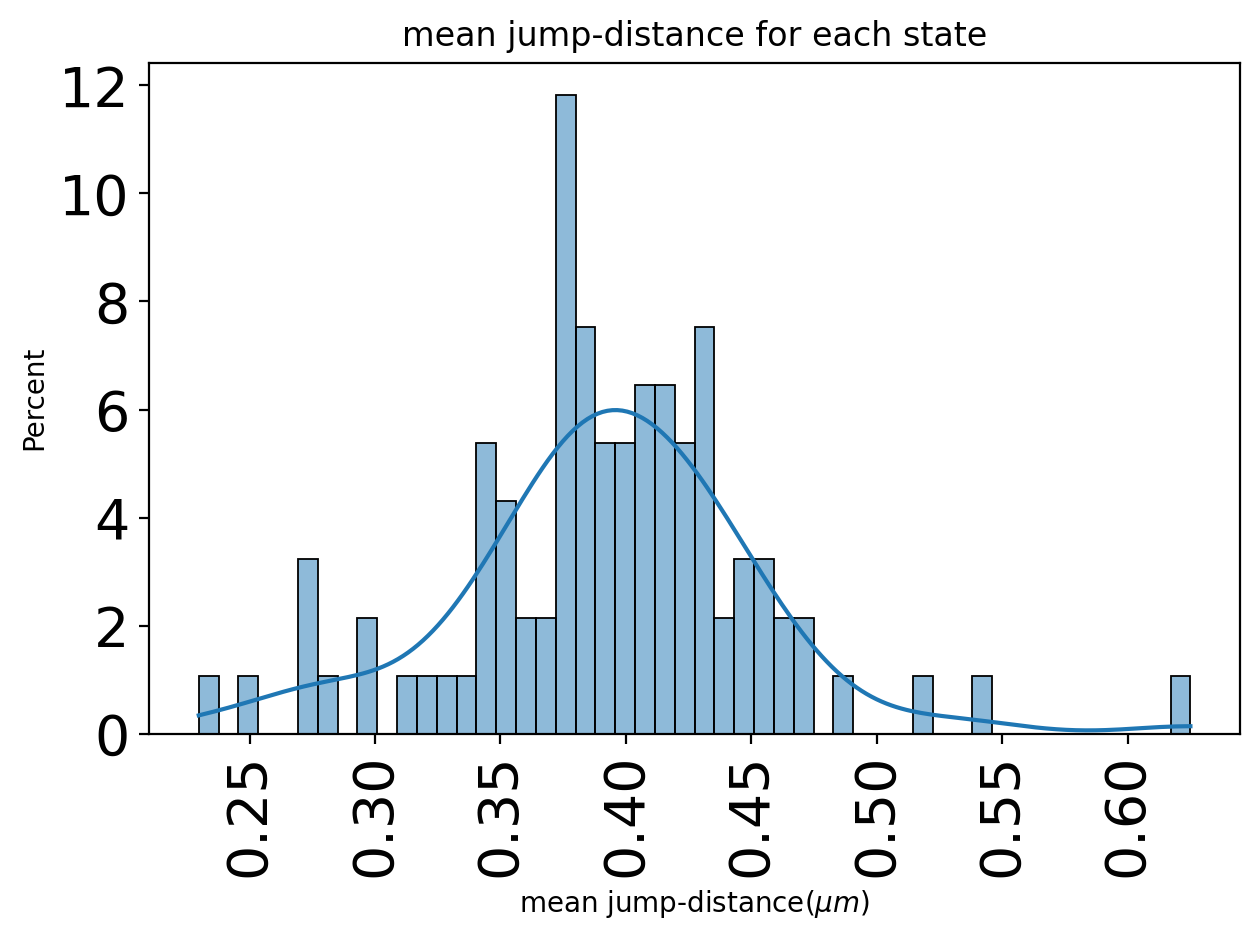

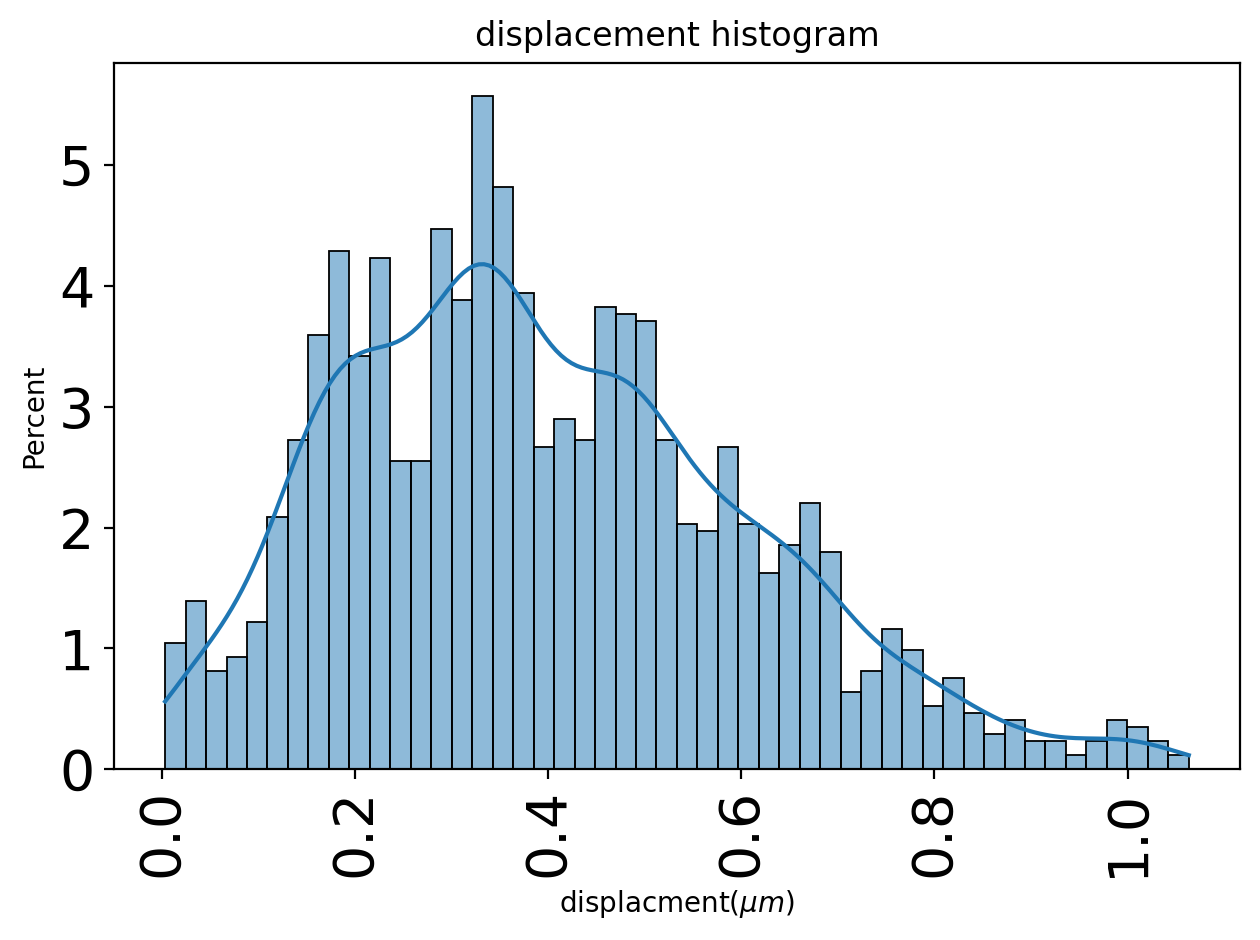

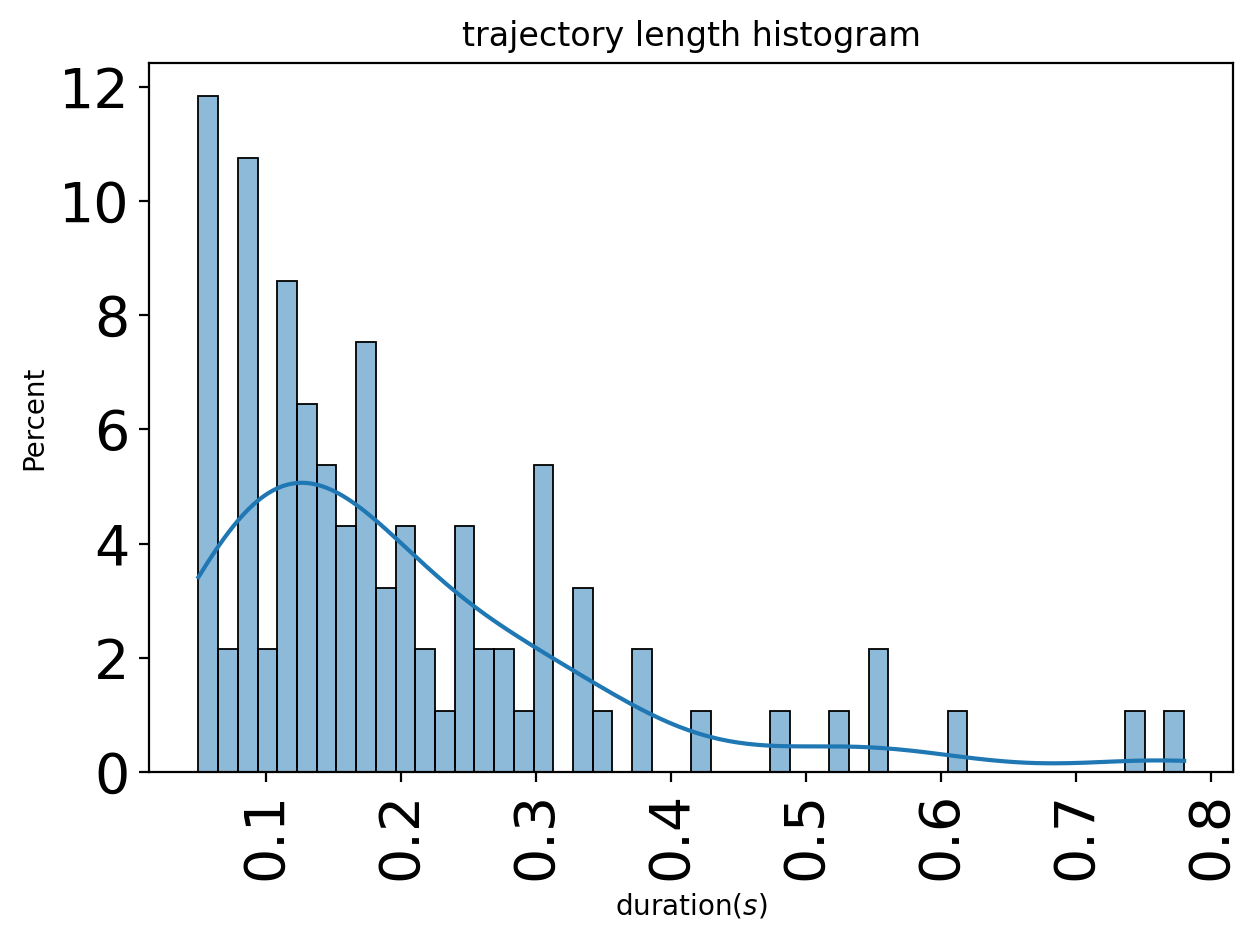

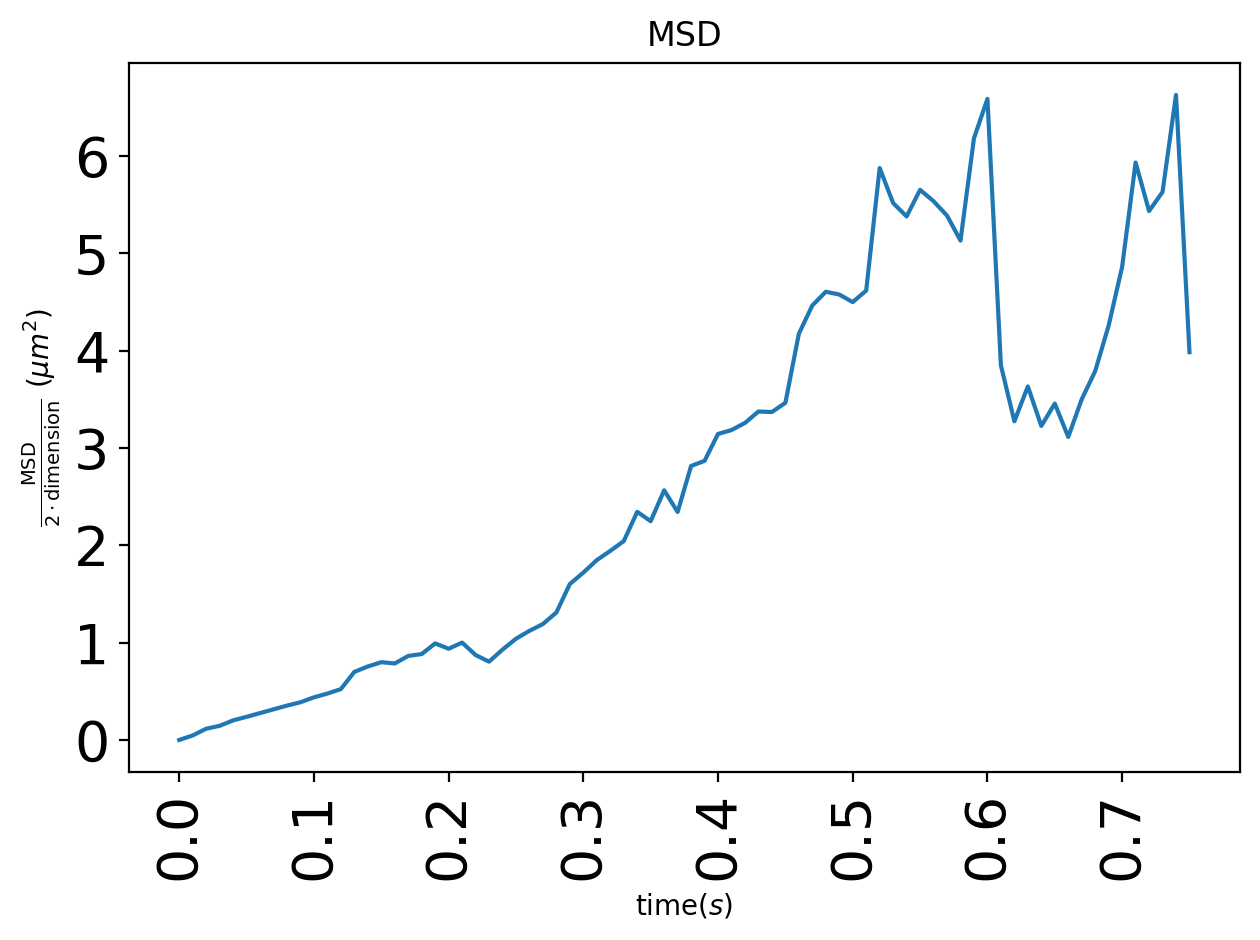

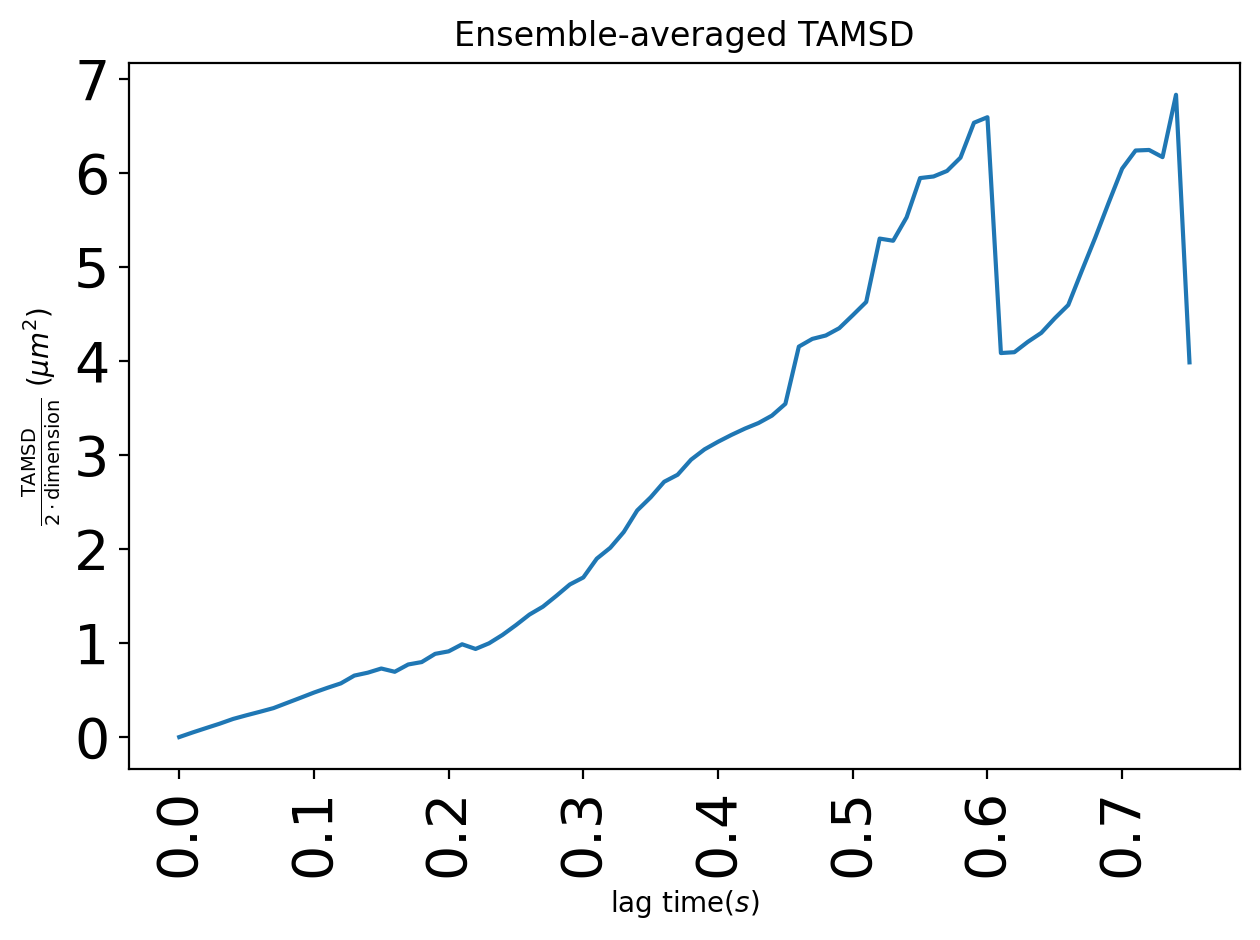

In [5]:
"""
From here, we treat data to make plots or print results.
Data is stored as
1. analysis_data1: (DataFrame: contains data of mean_jump_distance, duration, traj_id, color_code)
2. analysis_data2: (DataFrame: contains data of displacments, color_code)
3. msd: (DataFrame: contains msd.) 
4. tamsd: (DataFrame: contains ensemble-averaged tamsd.) 
-> ref: https://www.researchgate.net/publication/352833354_Characterising_stochastic_motion_in_heterogeneous_media_driven_by_coloured_non-Gaussian_noise
-> ref: https://arxiv.org/pdf/1205.2100

Units: 
mean_jump_disatnce: set of averages of jump distances in um.
duration: duration of trajectory in seconds.
displacement: displacement(time lag=1) of all trajectories in um.
"""


#p1: histogram with kde(kernel density estimation) plot of mean jump distance grouped by state.
plt.figure(f'p1', dpi=figure_resolution_in_dpi)
p1 = sns.histplot(analysis_data1, x=f'mean_jump_d', stat='percent', bins=number_of_bins, kde=True)
p1.set_xlabel(r'mean jump-distance($\mu m$)')
p1.set_title(f'mean jump-distance for each state')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()


#p2: displacement histogram
plt.figure(f'p2', dpi=figure_resolution_in_dpi)
p2 = sns.histplot(data=analysis_data2, x='displacements', stat='percent', bins=number_of_bins, kde=True)
p2.set_title(f'displacement histogram')
p2.set_xlabel(r'displacment($\mu m$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()


#p3: trajectory length(sec) histogram
plt.figure(f'p3', dpi=figure_resolution_in_dpi)
p3 = sns.histplot(data=analysis_data1, x='duration', stat='percent', bins=number_of_bins, kde=True)
p3.set_title(f'trajectory length histogram')
p3.set_xlabel(r'duration($s$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()


#p4: MSD
plt.figure(f'p4', dpi=figure_resolution_in_dpi)
p4 = sns.lineplot(data=msd, x=msd['time'], y=msd['mean'])
p4.set_title(f'MSD')
p4.set_xlabel(r'time($s$)')
p4.set_ylabel(r'$\frac{\text{MSD}}{\text{2} \cdot \text{dimension}}$ ($\mu m^2$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()


#p5: Ensemble-averaged TAMSD
plt.figure(f'p5', dpi=figure_resolution_in_dpi)
p5 = sns.lineplot(data=tamsd, x=tamsd['time'], y=tamsd['mean'])
p5.set_title(f'Ensemble-averaged TAMSD')
p5.set_xlabel(r'lag time($s$)')
p5.set_ylabel(r'$\frac{\text{TAMSD}}{\text{2} \cdot \text{dimension}}$ ($\mu m^2$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()